Predicting Neural Activity in Mice

Cody Vig

March 17, 2025

To convert without code, use 
```bash
jupyter nbconvert report.ipynb --to html --no-input
```

In [1]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [2]:
from scripts.mouse import Mouse

cori = [Mouse(i) for i in range(1, 4)]
forssmann = [Mouse(i) for i in range(4, 8)]
hench = [Mouse(i) for i in range(8, 12)]
lederberg = [Mouse(i) for i in range(12, 19)]

mice = [cori, forssmann, hench, lederberg]

In [3]:
plt.style.use('seaborn-v0_8-notebook')

# Abstract

Visual stimuli elicit neurological activity that is correlated with the decision-making processes. In this study, we analyze a subset of data collected by Steinmetz et al. [[1]](https://doi.org/10.1038/s41586-019-1787-x) to examine the relationship between neuronal activation in mice, external stimulation, and subsequent decision outcomes. We conduct an exploratory data analysis to compare success rates and neuron spike patterns across different mice and experimental sessions. Relevant features are then selected for the development of a predictive model aimed at forecasting mice responses. The model's performance is evaluated using test sets, and the results are analyzed and discussed.

# Introduction

A subset of the data collected by Steinmetz et al. [[1]](https://doi.org/10.1038/s41586-019-1787-x) in 2019 were examined. In their original paper, the authors conducted a study on 10 mice over a total of 39 sessions, in which the mice were presented with visual stimuli and then required to make a decision based on that stimului. The mice were given a reward or penalty based on whether or not they behaved in a manner agreed upon by the authors in advance of the experiment.

Each session consisted of several hundreds of trials, and the the neural activity of each mouse was monitored during each trial. In this paper, we access a subset of the original author's data, which consists of the first 18 sessions of four of the 10 mice, named Cori, Forssmann, Hench, and Lederberg. We perform basic exploratory data analysis on the neural activity and then attempt to build a model to predict their behavior based on the stimuli. 

# Exploratory Data Analysis

The present data are paritioned into 18 sessions with four different mice. Each session comprises of several hundreds of trials. To begin, we compare the rate of correct responses across the four mice.

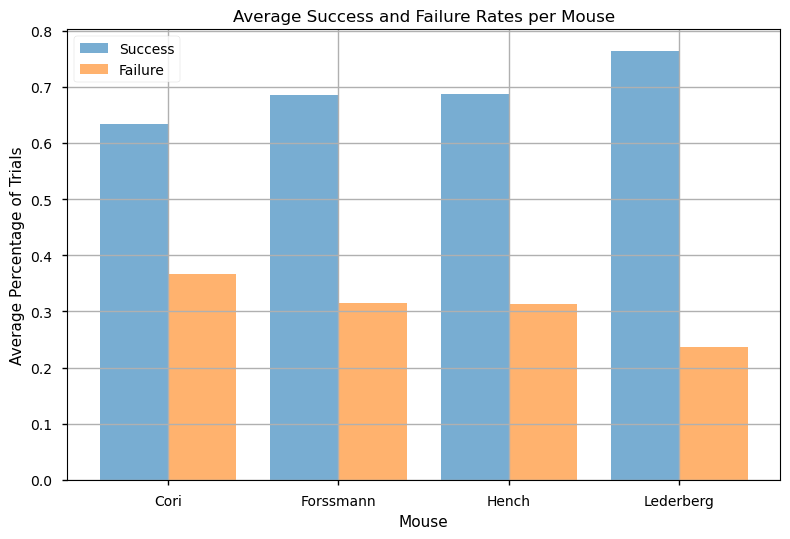

In [4]:
bar_width = 0.4
num_mice = len(mice)
x = np.arange(num_mice)

success_rates = []
failure_rates = []

for mouse in mice:
    success = np.mean(
        [sum(session.feedback_type == 1) / len(session.feedback_type) for session in mouse]
    )
    failure = np.mean(
        [sum(session.feedback_type == -1) / len(session.feedback_type) for session in mouse]
    )
    success_rates.append(success)
    failure_rates.append(failure)

plt.bar(x - bar_width/2, success_rates, width=bar_width, label='Success', alpha=0.6)
plt.bar(x + bar_width/2, failure_rates, width=bar_width, label='Failure', alpha=0.6)

plt.xlabel('Mouse')
plt.ylabel('Average Percentage of Trials')
plt.title('Average Success and Failure Rates per Mouse')
plt.xticks(x, [mouse[0].mouse_name for mouse in mice])
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

All four mice are generally correct in their responses more often than would be prescribed by random chance, indicating that some level of learning is occurring. Based only on success rates, Cori is the best performer, while Lederberg is the worst.

Next we consider the structure of the average brain activity in each mouse. Here we examine the number of brain areas in which at least one neuron is active during at least one trial.

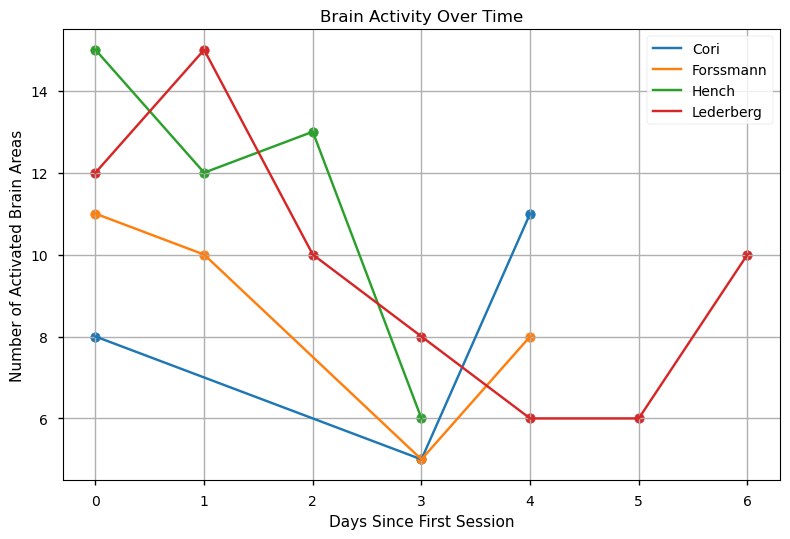

In [5]:
for mouse in mice:
    first_date = min(session.date_exp for session in mouse)
    days_since_first = [(session.date_exp - first_date).days for session in mouse]
    brain_areas = [len(session.brain_areas) for session in mouse]
    mouse_name = mouse[0].mouse_name
    plt.plot(days_since_first, brain_areas, label=mouse_name)
    plt.scatter(days_since_first, brain_areas)

plt.xlabel('Days Since First Session')
plt.ylabel('Number of Activated Brain Areas')
plt.title('Brain Activity Over Time')
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

Interestingly, we see the average brain activity of the mice generally decrease as the sessions progress. This could be due to the mice becoming more familiar with the task and thus requiring less brain activity to complete it. However, despite the aggregations occuring in the plot, the data are quite noisy and it is difficult to draw any concrete conclusions from this figure alone. Further analysis is needed to determine if there is a significant correlation between the number of activated brain areas and the days since the first session, but this analysis is better suited for a separate study.

Next, we examine neurological activity in the mice by plotting the average number of spikes detected in any area of the brain for one of the mice in the first trial of their first session versus their last trial of their last session. The data we have on Cori is limited, so we will use the data from the second mouse, Forssmann, for this analysis.

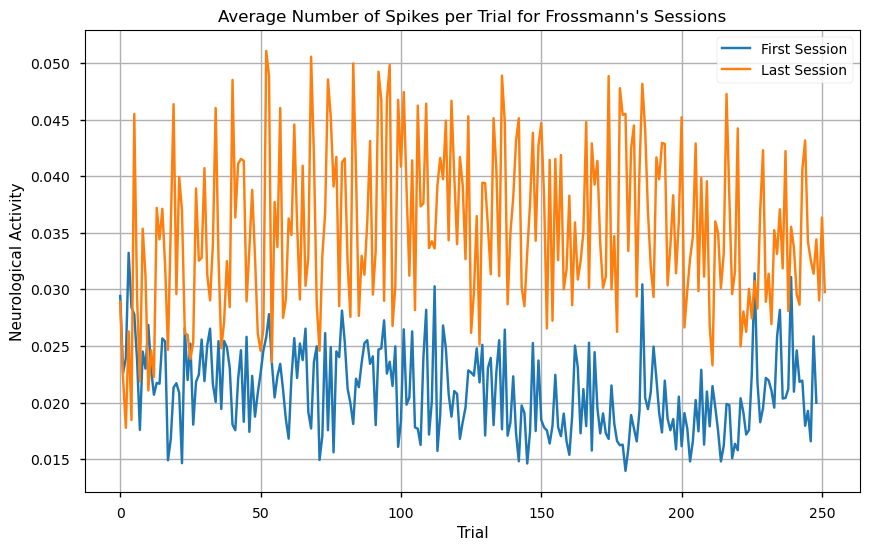

In [6]:
frossmann = mice[1]

spikes_per_first_trial = []
spikes_per_last_trial = []

first_trial = frossmann[0]
for trial in first_trial.list_of_trials:
    spikes = first_trial.spikes.get(trial)
    spikes = spikes.astype(int)
    spikes_per_first_trial.append(spikes.mean().mean())

last_trial = frossmann[-1]
for trial in last_trial.list_of_trials:
    spikes = last_trial.spikes.get(trial)
    spikes = spikes.astype(int)
    spikes_per_last_trial.append(spikes.mean().mean())

plt.figure(figsize=(10, 6))
plt.plot(spikes_per_first_trial, label='First Session')
plt.plot(spikes_per_last_trial, label='Last Session')
plt.xlabel('Trial')
plt.ylabel('Neurological Activity')
plt.title("Average Number of Spikes per Trial for Frossmann's Sessions")
plt.legend()
plt.grid()
plt.show()

This graph shows the average number of spikes for the first trial of session 4 and the last trial of session 7, with the x-axis representing trial numbers the y-axis representing the average spike counts. The variability of the data is represented, showing how the various activities of the neurons can vary. The data are very noisy, but some regularity can be ascertained. Interestingly, the mean neurological activity seems to have significantly increased from the first trial to the last, which seems to directly contradict the observation above about the general decrease in brain activity through the sessions. This discrepancy could be due to the fact that the data are very noisy and that the average number of spikes is not a very good measure of brain activity. It is also possible that the neurons that are active in the first trial are not the same as those that are active in the last trial, which would explain the discrepancy. This graph could be improved by using a more robust measure of brain activity, such as the number of neurons that are active in a given trial, rather than the average number of spikes.

To address the concerns illuminated above, we aim to track which regions of the brain are activated in each trial, and how this activation changes over time. In the figure below, we construct one plot per mouse that lists the brain regions that were activated in each session. The data are then paritioned by session date to distinguish the brain regions that were activated in each session. In this case, the $x$-axis represents the total number of neurological spikes in each region of the brain and the y axis enumerates those regions.

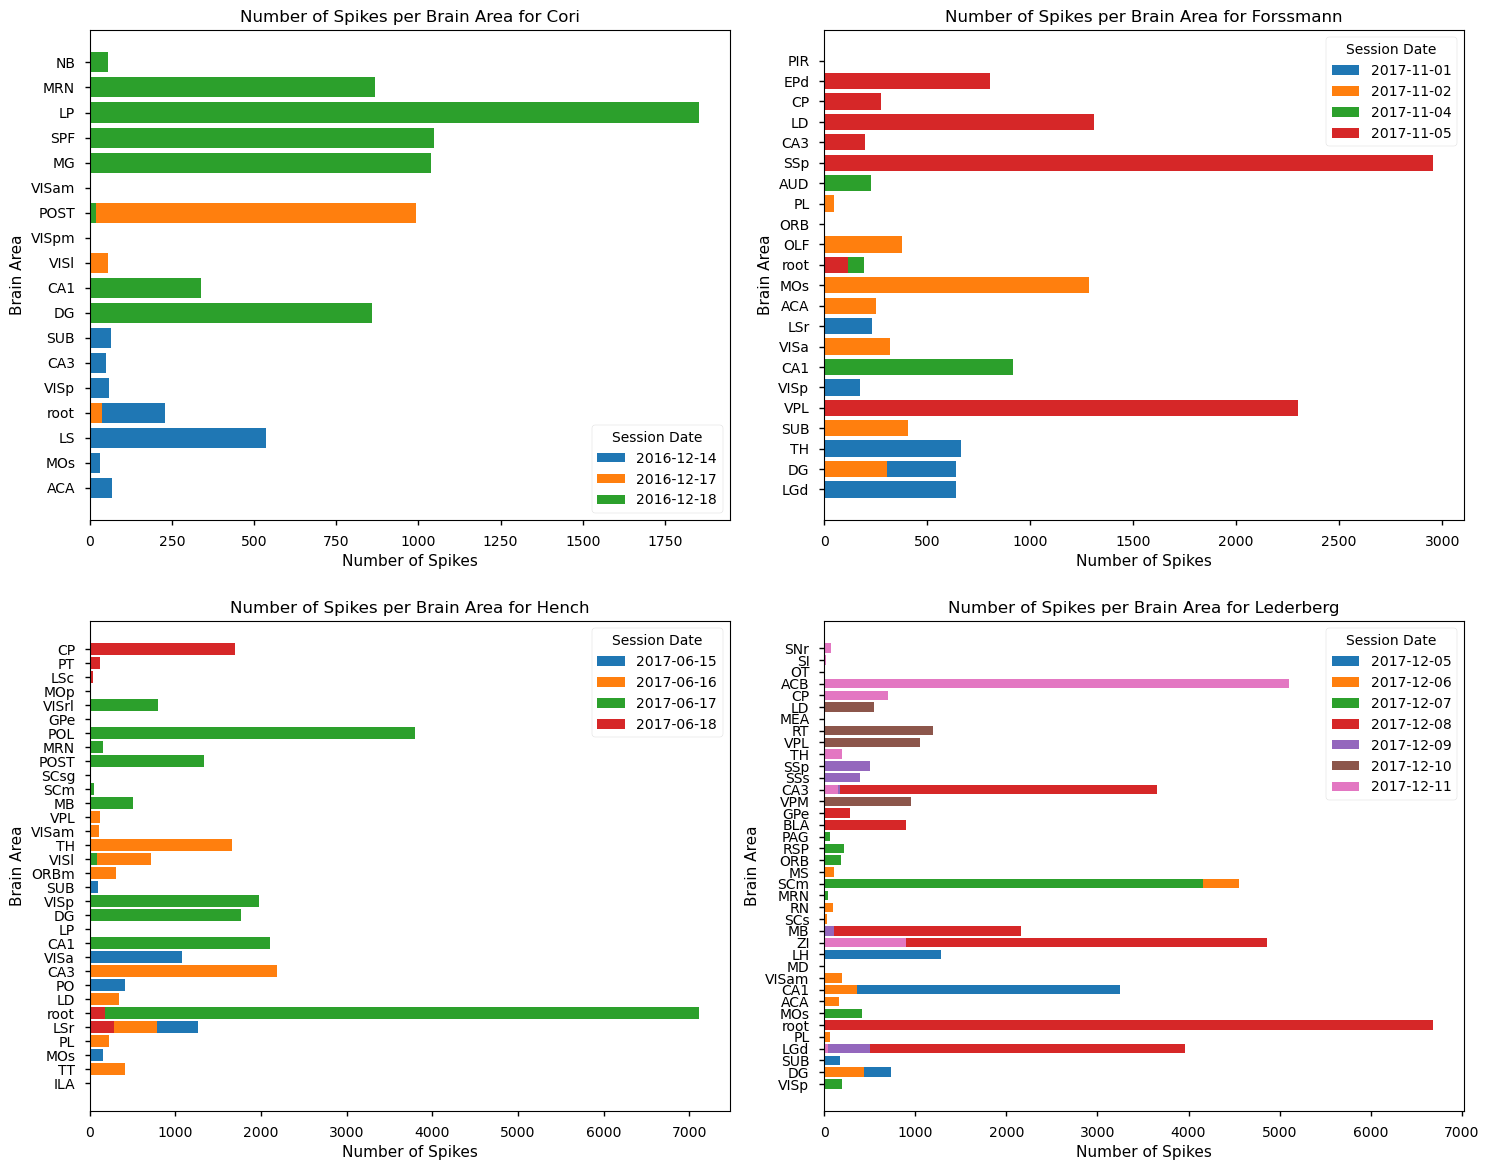

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

mice_names = ["cori", "forssmann", "hench", "lederberg"]
mice_list = [cori, forssmann, hench, lederberg]

for ax, mouse, name in zip(axs.flatten(), mice_list, mice_names):
    session_neurons = {}
    for session in mouse:
        activated_neurons = {}
        for trial in session.list_of_trials:
            spikes = session.spikes.get(trial).astype(int)
            spikes_per_neuron = spikes.T.sum().to_dict()
            for neuron, activation in spikes_per_neuron.items():
                if neuron in activated_neurons:
                    activated_neurons[neuron] += activation
                else:
                    activated_neurons[neuron] = activation

        session_neurons[session.date_exp] = activated_neurons

    session_dates = list(session_neurons.keys())
    neuron_data = list(session_neurons.values())

    for date, neurons in zip(session_dates, neuron_data):
        neuron_names = list(neurons.keys())
        spike_counts = list(neurons.values())
        ax.barh(neuron_names, spike_counts, label=str(date))

    ax.set_xlabel("Number of Spikes")
    ax.set_ylabel("Brain Area")
    ax.set_title(f"Number of Spikes per Brain Area for {name.capitalize()}")
    ax.legend(title="Session Date")

plt.tight_layout()
plt.gcf().set_size_inches(15, 12)
plt.show()

Although the delineation is not perfect, there appears to be a generally distinct pattern collection of brain areas active in each session. For instance, Cori sees strong activation in the SUB, CA3, root, LS, MOs, and ACA regions of the brain during their first session, dominant activity in POST and VISI during their second, and significant activation in NB, MRN, LP, SPF, MG, CA1, and DG during their final session. There is some overlap between sessions, but that overlap is trivial compared to the dominant region of activation. The trend is less pronounced in the other mice, but the general pattern of distinct activation regions per session is still present.

It is for this resaon that region of activation will serve as a good predictor of the mouse's decision in response to the stimuli. In the next section, we will use this data to train a variety of predictive models aimed at determining the mouse's response to the stimuli based on the brain region activated.

# Data Integration

In this section, we perform necessary data engineering to prepare the data for predictive modeling. In the previous section, we discussed what features might be significant in predicting the success of a trial. We will use these features to train a model that can predict the success of a trial based on the neural activity data.

It will be useful for the sake of bookkeeping to keep track of which session and which mouse each row of data corresponds to. We will add these columns to the data before proceeding with the modeling, but they will not be used in the training of the model. Beyond that, it may be best to consider one row per trial of a session to help mitigate the effects of overfitting. Aside from the metadata features, we will consider the average activation of each brain area as a feature, in the same way that we did in the exploratory data analysis section.

A preview of the data after these transformations is shown below.

In [8]:
# Gather model features for all sessions.

global_features = pd.DataFrame()
for mouse in mice:
    for session in mouse:
        session.model_features
        session.model_features = session.model_features.reindex(
            columns=global_features.columns.union(session.model_features.columns),
            fill_value=0,
        )
        global_features = pd.concat([global_features, session.model_features])

# Leave the metadata columns alone, but order the brain area columns in
# alphabetical order
metadata = global_features.columns[:5].tolist()
brain_areas = sorted(global_features.columns[5:])
global_features[brain_areas] = global_features[brain_areas].fillna(0)
global_features = global_features[metadata + brain_areas]

global_features.head()

,Mouse,Session,Trial,Decision,Feedback,ACA,ACB,AUD,BLA,CA1,...,VISa,VISam,VISl,VISp,VISpm,VISrl,VPL,VPM,ZI,root
0,Cori,1,1,2,1.0,1.266055,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.685393,0.0,0.0,0.0,0.0,0.0,0.500000
1,Cori,1,2,3,1.0,0.587156,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.651685,0.0,0.0,0.0,0.0,0.0,0.666667
2,Cori,1,3,2,-1.0,1.192661,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.275281,0.0,0.0,0.0,0.0,0.0,1.444444
3,Cori,1,4,3,-1.0,0.513761,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.561798,0.0,0.0,0.0,0.0,0.0,1.055556
4,Cori,1,5,3,-1.0,0.770642,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.623596,0.0,0.0,0.0,0.0,0.0,0.777778


The regions of the brain are listed in alphabetical order. Of note, most of them are null. This is not a coincidence. The data is sparse, and most of the brain regions are not activated in most of the sessions. This is a common problem in neuroscience, where the data is sparse and high-dimensional. It begs the question of how many features are necessary to predict the outcome of a session. We can use PCA to reduce the dimensionality of the data, we could omit the brain regions that are almost never activated, or we can do a combination of both.

First, let's consider how the models perform when omiting the brain regions that are almost never activated. Below is a plot of the proportion of trials over all 18 sessions for which each brain region is not activated.

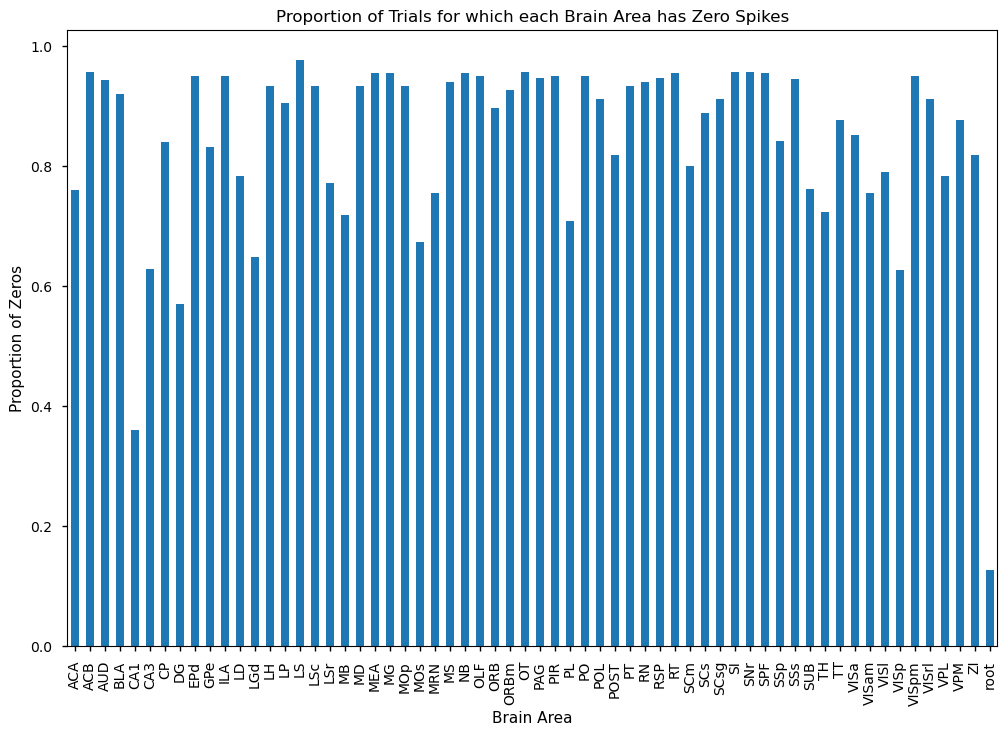

In [9]:
# Calculate the proportion of zeros for each brain area column
proportion_zeros = (global_features[brain_areas] == 0).mean()

# Plot the proportion of zeros
plt.figure(figsize=(12, 8))
proportion_zeros.plot(kind="bar")
plt.title("Proportion of Trials for which each Brain Area has Zero Spikes")
plt.xlabel("Brain Area")
plt.ylabel("Proportion of Zeros")
plt.show()

There are significantly many brain regions which receive essentially zero neurological activity in the form of spikes for any mouse across all sessions. This is a good thing, as it means that the data is sparse and that the model will have to learn from the non-zero values. Thus, we choose a threshold of 0.9 to remove brain areas which are essentially always zero; that is, any brain region which has a proportion of zeros greater than 0.9 will be removed from the dataset.

This reduces the number of potential features from 67 down to 34. A sample of this new dataset is shown below.

In [10]:
# Filter columns based on proportion_zeros
filtered_columns = proportion_zeros[proportion_zeros < 0.9].index.tolist()
filtered_columns = metadata + filtered_columns
filtered_features = global_features[filtered_columns]
filtered_features.head()

,Mouse,Session,Trial,Decision,Feedback,ACA,CA1,CA3,CP,DG,...,TH,TT,VISa,VISam,VISl,VISp,VPL,VPM,ZI,root
0,Cori,1,1,2,1.0,1.266055,0.0,1.529412,0.0,2.323529,...,0.0,0.0,0.0,0.0,0.0,1.685393,0.0,0.0,0.0,0.500000
1,Cori,1,2,3,1.0,0.587156,0.0,1.705882,0.0,1.558824,...,0.0,0.0,0.0,0.0,0.0,1.651685,0.0,0.0,0.0,0.666667
2,Cori,1,3,2,-1.0,1.192661,0.0,1.985294,0.0,3.411765,...,0.0,0.0,0.0,0.0,0.0,2.275281,0.0,0.0,0.0,1.444444
3,Cori,1,4,3,-1.0,0.513761,0.0,2.191176,0.0,2.205882,...,0.0,0.0,0.0,0.0,0.0,1.561798,0.0,0.0,0.0,1.055556
4,Cori,1,5,3,-1.0,0.770642,0.0,1.808824,0.0,2.058824,...,0.0,0.0,0.0,0.0,0.0,1.623596,0.0,0.0,0.0,0.777778


Next, prinipal component analysis is conducted to reduce the dimensionality of the data. The first twwo principal components are plotted to visualize the data in hopes of finding clusters.

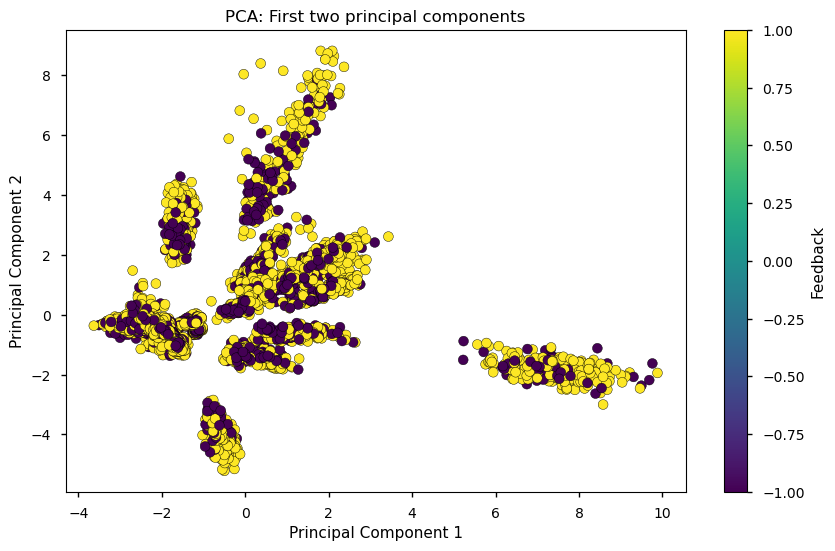

In [11]:

X = filtered_features.drop(columns=['Feedback', "Mouse", "Session"])
y = filtered_features['Feedback']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.select_dtypes(include=[float]))

pca = PCA(n_components=None)
principal_components = pca.fit_transform(X_scaled)

# Plot the first two principal components
plt.figure(figsize=(10, 6))
plt.scatter(
    principal_components[:, 0],
    principal_components[:, 1],
    c=y,
    cmap="viridis",
    edgecolor="k",
    s=50,
)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA: First two principal components')
plt.colorbar(label='Feedback')
plt.show()

Significant clustering is observed in the PCA plot, which suggests that the data is separable. Unfortuantely, the clusters do not appear to reasonably partition the data based on the feedback type. This suggests that the data is not linearly separable, and that a linear classifier may not be the best choice for this data. For this reason, the principal compnents will not be used for classification. When the models were trained on the principal components, they were found it be slightly less accurate than when trained on the original features.

Nevertheless, it is insightful to view the explained variance of the principal components to see how much of the variance is captured by each component. Below is a plot of the cumulative explained variance of the principal components.

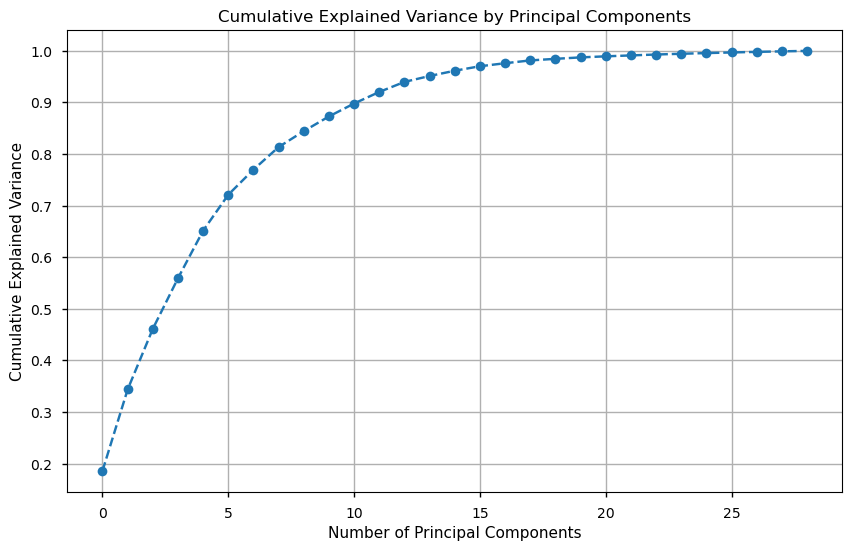

In [12]:
# Calculate the cumulative explained variance
cumulative_explained_variance = pca.explained_variance_ratio_.cumsum()

# Plot the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(cumulative_explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Principal Components')
plt.grid(True)
plt.show()

It only takes about 15 principal components to explain 95\% of the variance in the original data set. This is a reasonable jump in efficiency from the 34 present in the current data set. Nonetheless, for the sake of classification accuracy, we elect to use the 34 columns that can be more easily interpreted for the purposes of this model.

In the following section, we use these features to train a classifier to predict the feedback type (i.e., the mouse's response) to a trial.

# Predictive Modeling

Lorem ipsum dolor sit amet, consectetur adipiscing elit. Nulla lorem massa, sagittis eu gravida at, consectetur nec erat. Fusce quis magna in massa interdum dapibus at sed mi. Nulla quis sem purus. Suspendisse porttitor finibus quam, ut luctus dui fermentum at. Etiam iaculis a urna at varius. Donec facilisis leo pharetra accumsan tristique. Cras lorem nibh, iaculis eu finibus quis, fringilla ac nibh. Nam ut nunc laoreet, laoreet ipsum vel, feugiat nisl. Duis eu justo ac libero pellentesque varius. Integer vel massa aliquam, mollis lacus sed, dictum orci. Vestibulum venenatis nibh eget lectus bibendum tempor.

Fusce condimentum non ipsum id suscipit. Sed lobortis quam sit amet lorem auctor ultricies. Integer erat orci, hendrerit et rhoncus vel, luctus vel tellus. Suspendisse sit amet aliquet quam. In vel mi eget dolor iaculis venenatis. Etiam suscipit sem a arcu sagittis, id porttitor turpis semper. Nullam sed orci sagittis, ultrices dolor eget, rhoncus nisl.

Mauris dapibus efficitur mauris vitae tempor. Morbi pellentesque lectus sed tellus convallis, sit amet egestas metus lacinia. Cras accumsan fermentum libero, eget tristique ante dapibus vel. Nam elit dui, malesuada pulvinar elementum eget, ultrices id diam. Quisque vel erat mauris. Lorem ipsum dolor sit amet, consectetur adipiscing elit. Nam orci ante, ultricies non nunc et, euismod consectetur sapien. Cras elementum magna nibh, non gravida nunc blandit vel. Donec gravida mattis hendrerit. Vestibulum ante ipsum primis in faucibus orci luctus et ultrices posuere cubilia curae; Aliquam vel blandit ipsum, non bibendum tellus. Aenean iaculis dolor ac sollicitudin egestas.

Aliquam erat volutpat. Maecenas id fringilla enim. Ut elementum purus augue, vel bibendum dui interdum ac. Aenean arcu augue, feugiat at euismod a, elementum a justo. Pellentesque hendrerit nisi ut urna fermentum, sed sagittis ipsum interdum. Duis ullamcorper luctus odio quis sodales. Sed sollicitudin ante sed urna tempor ornare. Phasellus laoreet porta massa non ullamcorper. Interdum et malesuada fames ac ante ipsum primis in faucibus. Aliquam a accumsan elit. Suspendisse sollicitudin iaculis tincidunt. Curabitur maximus leo in interdum malesuada. Sed pretium efficitur aliquam. Integer vel interdum libero, sed accumsan sapien. Donec facilisis vestibulum tortor, sed faucibus velit.

Proin ac augue maximus, eleifend lectus eu, eleifend neque. Cras volutpat bibendum arcu, luctus lobortis nisl malesuada ac. Aliquam erat volutpat. Quisque id orci sed leo egestas rutrum quis eget enim. Pellentesque ipsum erat, vestibulum at leo non, tincidunt viverra lorem. Pellentesque eu consectetur nulla. Proin ut aliquam urna. Etiam nec urna sit amet arcu luctus tincidunt. Cras bibendum congue est. Cras ornare ac ligula id ullamcorper. Morbi eu ex in dui consectetur sollicitudin. Maecenas eget est non erat euismod dapibus laoreet vel velit. Maecenas sed porta mi. Curabitur commodo arcu non nulla pharetra fermentum. Integer efficitur, ante at ultricies vestibulum, mauris diam venenatis neque, sit amet pharetra ipsum nisl scelerisque nisi. 

In [13]:
# Filter columns based on proportion_zeros
filtered_columns = proportion_zeros[proportion_zeros < 0.9].index.tolist()
filtered_columns = metadata + filtered_columns
filtered_features = global_features[filtered_columns]
filtered_features.head()

# Begin model training
X = filtered_features.drop(columns=['Feedback', "Mouse", "Session"])
y = filtered_features['Feedback']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.select_dtypes(include=[float]))

# Define the models to test
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machine': SVC(),
}

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    y,
    test_size=0.2,
    random_state=0
)

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(f"Model: {name}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\n" + "="*60 + "\n")


# Retrain the random forest model on the entire data set
random_forest = RandomForestClassifier()
random_forest.fit(X_scaled, y)

Model: Logistic Regression
Accuracy: 0.7129
Classification Report:
              precision    recall  f1-score   support

        -1.0       0.31      0.01      0.03       287
         1.0       0.72      0.99      0.83       730

    accuracy                           0.71      1017
   macro avg       0.51      0.50      0.43      1017
weighted avg       0.60      0.71      0.60      1017

Confusion Matrix:
[[  4 283]
 [  9 721]]


Model: Random Forest
Accuracy: 0.6942
Classification Report:
              precision    recall  f1-score   support

        -1.0       0.41      0.20      0.27       287
         1.0       0.74      0.89      0.81       730

    accuracy                           0.69      1017
   macro avg       0.58      0.54      0.54      1017
weighted avg       0.65      0.69      0.65      1017

Confusion Matrix:
[[ 57 230]
 [ 81 649]]


Model: Support Vector Machine
Accuracy: 0.7198
Classification Report:
              precision    recall  f1-score   support

       

RandomForestClassifier()

Lorem ipsum dolor sit amet, consectetur adipiscing elit. Nulla lorem massa, sagittis eu gravida at, consectetur nec erat. Fusce quis magna in massa interdum dapibus at sed mi. Nulla quis sem purus. Suspendisse porttitor finibus quam, ut luctus dui fermentum at. Etiam iaculis a urna at varius. Donec facilisis leo pharetra accumsan tristique. Cras lorem nibh, iaculis eu finibus quis, fringilla ac nibh. Nam ut nunc laoreet, laoreet ipsum vel, feugiat nisl. Duis eu justo ac libero pellentesque varius. Integer vel massa aliquam, mollis lacus sed, dictum orci. Vestibulum venenatis nibh eget lectus bibendum tempor.

# Prediction Performance on the Test Sets

Lorem ipsum dolor sit amet, consectetur adipiscing elit. Nulla lorem massa, sagittis eu gravida at, consectetur nec erat. Fusce quis magna in massa interdum dapibus at sed mi. Nulla quis sem purus. Suspendisse porttitor finibus quam, ut luctus dui fermentum at. Etiam iaculis a urna at varius. Donec facilisis leo pharetra accumsan tristique. Cras lorem nibh, iaculis eu finibus quis, fringilla ac nibh. Nam ut nunc laoreet, laoreet ipsum vel, feugiat nisl. Duis eu justo ac libero pellentesque varius. Integer vel massa aliquam, mollis lacus sed, dictum orci. Vestibulum venenatis nibh eget lectus bibendum tempor.

Fusce condimentum non ipsum id suscipit. Sed lobortis quam sit amet lorem auctor ultricies. Integer erat orci, hendrerit et rhoncus vel, luctus vel tellus. Suspendisse sit amet aliquet quam. In vel mi eget dolor iaculis venenatis. Etiam suscipit sem a arcu sagittis, id porttitor turpis semper. Nullam sed orci sagittis, ultrices dolor eget, rhoncus nisl.

Mauris dapibus efficitur mauris vitae tempor. Morbi pellentesque lectus sed tellus convallis, sit amet egestas metus lacinia. Cras accumsan fermentum libero, eget tristique ante dapibus vel. Nam elit dui, malesuada pulvinar elementum eget, ultrices id diam. Quisque vel erat mauris. Lorem ipsum dolor sit amet, consectetur adipiscing elit. Nam orci ante, ultricies non nunc et, euismod consectetur sapien. Cras elementum magna nibh, non gravida nunc blandit vel. Donec gravida mattis hendrerit. Vestibulum ante ipsum primis in faucibus orci luctus et ultrices posuere cubilia curae; Aliquam vel blandit ipsum, non bibendum tellus. Aenean iaculis dolor ac sollicitudin egestas.

Aliquam erat volutpat. Maecenas id fringilla enim. Ut elementum purus augue, vel bibendum dui interdum ac. Aenean arcu augue, feugiat at euismod a, elementum a justo. Pellentesque hendrerit nisi ut urna fermentum, sed sagittis ipsum interdum. Duis ullamcorper luctus odio quis sodales. Sed sollicitudin ante sed urna tempor ornare. Phasellus laoreet porta massa non ullamcorper. Interdum et malesuada fames ac ante ipsum primis in faucibus. Aliquam a accumsan elit. Suspendisse sollicitudin iaculis tincidunt. Curabitur maximus leo in interdum malesuada. Sed pretium efficitur aliquam. Integer vel interdum libero, sed accumsan sapien. Donec facilisis vestibulum tortor, sed faucibus velit.

Proin ac augue maximus, eleifend lectus eu, eleifend neque. Cras volutpat bibendum arcu, luctus lobortis nisl malesuada ac. Aliquam erat volutpat. Quisque id orci sed leo egestas rutrum quis eget enim. Pellentesque ipsum erat, vestibulum at leo non, tincidunt viverra lorem. Pellentesque eu consectetur nulla. Proin ut aliquam urna. Etiam nec urna sit amet arcu luctus tincidunt. Cras bibendum congue est. Cras ornare ac ligula id ullamcorper. Morbi eu ex in dui consectetur sollicitudin. Maecenas eget est non erat euismod dapibus laoreet vel velit. Maecenas sed porta mi. Curabitur commodo arcu non nulla pharetra fermentum. Integer efficitur, ante at ultricies vestibulum, mauris diam venenatis neque, sit amet pharetra ipsum nisl scelerisque nisi. 

In [14]:
filtered_columns = [
    'Mouse', 'Session', 'Trial', 'Decision', 'Feedback', 'ACA', 'CA1',
    'CA3', 'CP', 'DG', 'GPe', 'LD', 'LGd', 'LSr', 'MB', 'MOs', 'MRN', 'ORB',
    'PL', 'POST', 'SCm', 'SCs', 'SSp', 'SUB', 'TH', 'TT', 'VISa', 'VISam',
    'VISl', 'VISp', 'VPL', 'VPM', 'ZI', 'root'
]

# Load in the test data
test_mice = [
    [Mouse(1, test=True)],
    [Mouse(2, test=True)],
]

# Gather model features for all sessions.
global_features = pd.DataFrame()
for mouse in test_mice:
    for session in mouse:
        session.model_features
        session.model_features = session.model_features.reindex(
            columns=global_features.columns.union(session.model_features.columns),
            fill_value=0,
        )
        global_features = pd.concat([global_features, session.model_features])

# Leave the metadata columns alone, but order the brain area columns in
# alphabetical order
metadata = global_features.columns[:5].tolist()
brain_areas = sorted(global_features.columns[5:])
global_features[brain_areas] = global_features[brain_areas].fillna(0)
global_features = global_features[metadata + brain_areas]

# Ensure filtered_features only has the columns present in filtered_columns
filtered_features = global_features.reindex(columns=filtered_columns, fill_value=0)
filtered_features = filtered_features[filtered_columns]
filtered_features = filtered_features.loc[:, ~filtered_features.columns.duplicated()]

# Load the primary random forest model
random_forest_model = joblib.load('random_forest_model.pkl')

# Prepare the feature columns (excluding the target columns)
feature_cols = [
    col
    for col in filtered_features.columns
    if col not in ["Feedback", "Mouse", "Session", "Trial", "Decision"]
]

# Extract the features from the filtered_features dataframe
X_filtered = filtered_features[feature_cols]

# Predict the target using the primary random forest model
filtered_predictions = random_forest_model.predict(X_filtered)

# Add the predictions to the filtered_features dataframe
filtered_features['Predictions'] = filtered_predictions

# Extract the true labels for "Feedback"
true_feedback = filtered_features['Feedback']

# Calculate the accuracy of the model for predicting "Feedback"
feedback_accuracy = accuracy_score(true_feedback, filtered_predictions)

# Print the accuracy
print(
    f"Accuracy of the model for predicting 'Feedback': {feedback_accuracy:.2f}"
)

Accuracy of the model for predicting 'Feedback': 0.72


c:\Users\codyc\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


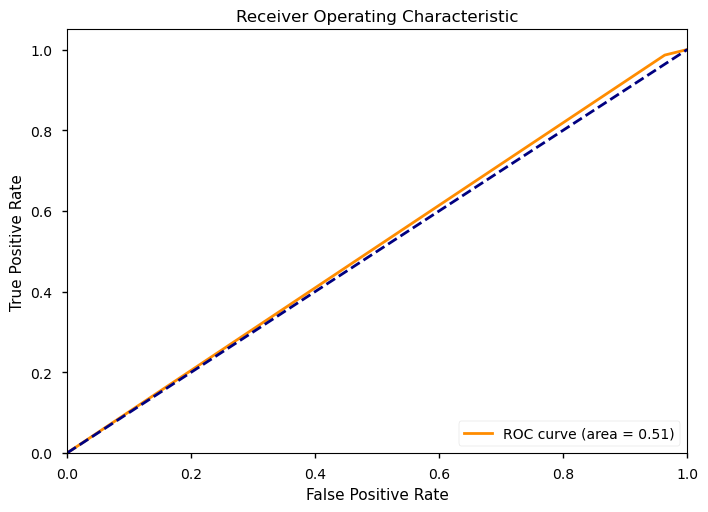

Confusion Matrix:
[[  2  53]
 [  2 143]]


In [15]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(true_feedback, filtered_predictions)

# Calculate the AUC (Area Under the Curve)
roc_auc = roc_auc_score(true_feedback, filtered_predictions)

# Plot the ROC curve
plt.figure()
plt.plot(
    fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})'
)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

conf_matrix = confusion_matrix(true_feedback, filtered_predictions)

print("Confusion Matrix:")
print(conf_matrix)

# Discussion

Lorem ipsum dolor sit amet, consectetur adipiscing elit. Nulla lorem massa, sagittis eu gravida at, consectetur nec erat. Fusce quis magna in massa interdum dapibus at sed mi. Nulla quis sem purus. Suspendisse porttitor finibus quam, ut luctus dui fermentum at. Etiam iaculis a urna at varius. Donec facilisis leo pharetra accumsan tristique. Cras lorem nibh, iaculis eu finibus quis, fringilla ac nibh. Nam ut nunc laoreet, laoreet ipsum vel, feugiat nisl. Duis eu justo ac libero pellentesque varius. Integer vel massa aliquam, mollis lacus sed, dictum orci. Vestibulum venenatis nibh eget lectus bibendum tempor.

Fusce condimentum non ipsum id suscipit. Sed lobortis quam sit amet lorem auctor ultricies. Integer erat orci, hendrerit et rhoncus vel, luctus vel tellus. Suspendisse sit amet aliquet quam. In vel mi eget dolor iaculis venenatis. Etiam suscipit sem a arcu sagittis, id porttitor turpis semper. Nullam sed orci sagittis, ultrices dolor eget, rhoncus nisl.

Mauris dapibus efficitur mauris vitae tempor. Morbi pellentesque lectus sed tellus convallis, sit amet egestas metus lacinia. Cras accumsan fermentum libero, eget tristique ante dapibus vel. Nam elit dui, malesuada pulvinar elementum eget, ultrices id diam. Quisque vel erat mauris. Lorem ipsum dolor sit amet, consectetur adipiscing elit. Nam orci ante, ultricies non nunc et, euismod consectetur sapien. Cras elementum magna nibh, non gravida nunc blandit vel. Donec gravida mattis hendrerit. Vestibulum ante ipsum primis in faucibus orci luctus et ultrices posuere cubilia curae; Aliquam vel blandit ipsum, non bibendum tellus. Aenean iaculis dolor ac sollicitudin egestas.

Aliquam erat volutpat. Maecenas id fringilla enim. Ut elementum purus augue, vel bibendum dui interdum ac. Aenean arcu augue, feugiat at euismod a, elementum a justo. Pellentesque hendrerit nisi ut urna fermentum, sed sagittis ipsum interdum. Duis ullamcorper luctus odio quis sodales. Sed sollicitudin ante sed urna tempor ornare. Phasellus laoreet porta massa non ullamcorper. Interdum et malesuada fames ac ante ipsum primis in faucibus. Aliquam a accumsan elit. Suspendisse sollicitudin iaculis tincidunt. Curabitur maximus leo in interdum malesuada. Sed pretium efficitur aliquam. Integer vel interdum libero, sed accumsan sapien. Donec facilisis vestibulum tortor, sed faucibus velit.

Proin ac augue maximus, eleifend lectus eu, eleifend neque. Cras volutpat bibendum arcu, luctus lobortis nisl malesuada ac. Aliquam erat volutpat. Quisque id orci sed leo egestas rutrum quis eget enim. Pellentesque ipsum erat, vestibulum at leo non, tincidunt viverra lorem. Pellentesque eu consectetur nulla. Proin ut aliquam urna. Etiam nec urna sit amet arcu luctus tincidunt. Cras bibendum congue est. Cras ornare ac ligula id ullamcorper. Morbi eu ex in dui consectetur sollicitudin. Maecenas eget est non erat euismod dapibus laoreet vel velit. Maecenas sed porta mi. Curabitur commodo arcu non nulla pharetra fermentum. Integer efficitur, ante at ultricies vestibulum, mauris diam venenatis neque, sit amet pharetra ipsum nisl scelerisque nisi. 

# References

[1] Steinmetz, N.A., Zatka-Haas, P., Carandini, M. et al. Distributed coding of choice, action and engagement across the mouse brain. Nature 576, 266–273 (2019). https://doi.org/10.1038/s41586-019-1787-x

# Appexdix | Code

Most of the code used to perform this analysis is not contained within this notebook, but in the package written for this project that can be found on [GitHub](https://github.com/CodyVig/predictive-modeling-py). Please visit the repoository for more information. The code that was used directly in this notebook is included below.

---
**Instantiating the Data**
```python
# Importing basic Data Science libraries
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd

# Importing data about the mice.
from scripts.mouse import Mouse # From the package written for this report.

cori = [Mouse(i) for i in range(1, 4)]
forssmann = [Mouse(i) for i in range(4, 8)]
hench = [Mouse(i) for i in range(8, 12)]
lederberg = [Mouse(i) for i in range(12, 19)]

mice = [cori, forssmann, hench, lederberg]
```

---
**Average Success and Failure Rates per Mouse**
```python
bar_width = 0.4
num_mice = len(mice)
x = np.arange(num_mice)

success_rates = []
failure_rates = []

for mouse in mice:
    success = np.mean(
        [sum(session.feedback_type == 1) / len(session.feedback_type) for session in mouse]
    )
    failure = np.mean(
        [sum(session.feedback_type == -1) / len(session.feedback_type) for session in mouse]
    )
    success_rates.append(success)
    failure_rates.append(failure)

plt.bar(x - bar_width/2, success_rates, width=bar_width, label='Success', alpha=0.6)
plt.bar(x + bar_width/2, failure_rates, width=bar_width, label='Failure', alpha=0.6)

plt.xlabel('Mouse')
plt.ylabel('Average Percentage of Trials')
plt.title('Average Success and Failure Rates per Mouse')
plt.xticks(x, [mouse[0].mouse_name for mouse in mice])
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()
```

---
**Brain Activity over Time**
```python
for mouse in mice:
    first_date = min(session.date_exp for session in mouse)
    days_since_first = [(session.date_exp - first_date).days for session in mouse]
    brain_areas = [len(session.brain_areas) for session in mouse]
    mouse_name = mouse[0].mouse_name
    plt.plot(days_since_first, brain_areas, label=mouse_name)
    plt.scatter(days_since_first, brain_areas)

plt.xlabel('Days Since First Session')
plt.ylabel('Number of Activated Brain Areas')
plt.title('Brain Activity Over Time')
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()
```

---
**Average Number of Spikes per Trial**
```python
frossmann = mice[1]

spikes_per_first_trial = []
spikes_per_last_trial = []

first_trial = frossmann[0]
for trial in first_trial.list_of_trials:
    spikes = first_trial.spikes.get(trial)
    spikes = spikes.astype(int)
    spikes_per_first_trial.append(spikes.mean().mean())

last_trial = frossmann[-1]
for trial in last_trial.list_of_trials:
    spikes = last_trial.spikes.get(trial)
    spikes = spikes.astype(int)
    spikes_per_last_trial.append(spikes.mean().mean())

plt.figure(figsize=(10, 6))
plt.plot(spikes_per_first_trial, label='First Session')
plt.plot(spikes_per_last_trial, label='Last Session')
plt.xlabel('Trial')
plt.ylabel('Neurological Activity')
plt.title("Average Number of Spikes per Trial for Frossmann's Sessions")
plt.legend()
plt.grid()
plt.show()
```

---
**Number of Spikes per Neuron per Session for Each Mouse**
```python
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

mice_names = ["cori", "forssmann", "hench", "lederberg"]
mice_list = [cori, forssmann, hench, lederberg]

for ax, mouse, name in zip(axs.flatten(), mice_list, mice_names):
    session_neurons = {}
    for session in mouse:
        activated_neurons = {}
        for trial in session.list_of_trials:
            spikes = session.spikes.get(trial).astype(int)
            spikes_per_neuron = spikes.T.sum().to_dict()
            for neuron, activation in spikes_per_neuron.items():
                if neuron in activated_neurons:
                    activated_neurons[neuron] += activation
                else:
                    activated_neurons[neuron] = activation

        session_neurons[session.date_exp] = activated_neurons

    session_dates = list(session_neurons.keys())
    neuron_data = list(session_neurons.values())

    for date, neurons in zip(session_dates, neuron_data):
        neuron_names = list(neurons.keys())
        spike_counts = list(neurons.values())
        ax.barh(neuron_names, spike_counts, label=str(date))

    ax.set_xlabel("Number of Spikes")
    ax.set_ylabel("Brain Area")
    ax.set_title(f"Number of Spikes per Brain Area for {name.capitalize()}")
    ax.legend(title="Session Date")

plt.tight_layout()
plt.gcf().set_size_inches(15, 12)
plt.show()
```

---
**Proportion of Trials for which each Brain Area has Zero Spikes**
```python
# Gather model features for all sessions.

global_features = pd.DataFrame()
for mouse in mice:
    for session in mouse:
        session.model_features
        session.model_features = session.model_features.reindex(
            columns=global_features.columns.union(session.model_features.columns),
            fill_value=0,
        )
        global_features = pd.concat([global_features, session.model_features])

# Leave the metadata columns alone, but order the brain area columns in
# alphabetical order
metadata = global_features.columns[:5].tolist()
brain_areas = sorted(global_features.columns[5:])
global_features[brain_areas] = global_features[brain_areas].fillna(0)
global_features = global_features[metadata + brain_areas]

# Calculate the proportion of zeros for each brain area column
proportion_zeros = (global_features[brain_areas] == 0).mean()

# Plot the proportion of zeros
plt.figure(figsize=(12, 8))
proportion_zeros.plot(kind="bar")
plt.title("Proportion of Trials for which each Brain Area has Zero Spikes")
plt.xlabel("Brain Area")
plt.ylabel("Proportion of Zeros")
plt.savefig("./figures/features_by_null_proportion.png")
plt.show()
```

---
**Principal Component Analysis**
```python
# Filter columns based on proportion_zeros
filtered_columns = proportion_zeros[proportion_zeros < 0.9].index.tolist()
filtered_columns = metadata + filtered_columns
filtered_features = global_features[filtered_columns]
filtered_features.head()

X = filtered_features.drop(columns=['Feedback', "Mouse", "Session"])
y = filtered_features['Feedback']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.select_dtypes(include=[float]))

pca = PCA(n_components=None)
principal_components = pca.fit_transform(X_scaled)

# Plot the first two principal components
plt.figure(figsize=(10, 6))
plt.scatter(
    principal_components[:, 0],
    principal_components[:, 1],
    c=y,
    cmap="viridis",
    edgecolor="k",
    s=50,
)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA: First two principal components')
plt.colorbar(label='Feedback')
plt.savefig('./figures/pca.png')
plt.show()
```

---
**Cumulative Explained Variance**
```python
# Calculate the cumulative explained variance
cumulative_explained_variance = pca.explained_variance_ratio_.cumsum()

# Plot the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(cumulative_explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Principal Components')
plt.grid(True)
plt.savefig('./figures/global_cumulative_explained_variance.png')
plt.show()
```

---
**Model Fitting and Assessment**
```python
# Filter columns based on proportion_zeros
filtered_columns = proportion_zeros[proportion_zeros < 0.9].index.tolist()
filtered_columns = metadata + filtered_columns
filtered_features = global_features[filtered_columns]
filtered_features.head()

# Begin model training
X = filtered_features.drop(columns=['Feedback', "Mouse", "Session"])
y = filtered_features['Feedback']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.select_dtypes(include=[float]))

# Define the models to test
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machine': SVC(),
}

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    y,
    test_size=0.2,
    random_state=0
)

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(f"Model: {name}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\n" + "="*60 + "\n")


# Retrain the random forest model on the entire data set
random_forest = RandomForestClassifier()
random_forest.fit(X_scaled, y)
```

---
**Testing the Model on the Test Sets**
```python
filtered_columns = [
    'Mouse', 'Session', 'Trial', 'Decision', 'Feedback', 'ACA', 'CA1',
    'CA3', 'CP', 'DG', 'GPe', 'LD', 'LGd', 'LSr', 'MB', 'MOs', 'MRN', 'ORB',
    'PL', 'POST', 'SCm', 'SCs', 'SSp', 'SUB', 'TH', 'TT', 'VISa', 'VISam',
    'VISl', 'VISp', 'VPL', 'VPM', 'ZI', 'root'
]

# Load in the test data
test_mice = [
    [Mouse(1, test=True)],
    [Mouse(2, test=True)],
]

# Gather model features for all sessions.
global_features = pd.DataFrame()
for mouse in test_mice:
    for session in mouse:
        session.model_features
        session.model_features = session.model_features.reindex(
            columns=global_features.columns.union(session.model_features.columns),
            fill_value=0,
        )
        global_features = pd.concat([global_features, session.model_features])

# Leave the metadata columns alone, but order the brain area columns in
# alphabetical order
metadata = global_features.columns[:5].tolist()
brain_areas = sorted(global_features.columns[5:])
global_features[brain_areas] = global_features[brain_areas].fillna(0)
global_features = global_features[metadata + brain_areas]

# Ensure filtered_features only has the columns present in filtered_columns
filtered_features = global_features.reindex(columns=filtered_columns, fill_value=0)
filtered_features = filtered_features[filtered_columns]
filtered_features = filtered_features.loc[:, ~filtered_features.columns.duplicated()]

# Load the primary random forest model
random_forest_model = joblib.load('random_forest_model.pkl')

# Prepare the feature columns (excluding the target columns)
feature_cols = [
    col
    for col in filtered_features.columns
    if col not in ["Feedback", "Mouse", "Session", "Trial", "Decision"]
]

# Extract the features from the filtered_features dataframe
X_filtered = filtered_features[feature_cols]

# Predict the target using the primary random forest model
filtered_predictions = random_forest_model.predict(X_filtered)

# Add the predictions to the filtered_features dataframe
filtered_features['Predictions'] = filtered_predictions

# Extract the true labels for "Feedback"
true_feedback = filtered_features['Feedback']

# Calculate the accuracy of the model for predicting "Feedback"
feedback_accuracy = accuracy_score(true_feedback, filtered_predictions)

# Print the accuracy
print(
    f"Accuracy of the model for predicting 'Feedback': {feedback_accuracy:.2f}"
)
```

---
**Receiver Operating Characteristic Curve**
```python
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(true_feedback, filtered_predictions)

# Calculate the AUC (Area Under the Curve)
roc_auc = roc_auc_score(true_feedback, filtered_predictions)

# Plot the ROC curve
plt.figure()
plt.plot(
    fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})'
)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.savefig('./figures/roc_curve.png')
plt.show()

conf_matrix = confusion_matrix(true_feedback, filtered_predictions)

print("Confusion Matrix:")
print(conf_matrix)
```

```